<a href="https://colab.research.google.com/github/shima2920/Kaggle/blob/main/New_York_City_Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

from google.colab import files
files.upload()
#Kaggle account で発行した API token key ファイルを Upload する。

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list


Saving kaggle.json to kaggle.json
ref                                                       title                                         size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
michau96/restaurant-business-rankings-2020                Restaurant Business Rankings 2020             16KB  2021-01-30 14:20:45           3201  
gpreda/reddit-wallstreetsbets-posts                       Reddit WallStreetBets Posts                    8MB  2021-02-24 07:59:48           1712  
yorkehead/stock-market-subreddits                         Stock Market Subreddits                        1MB  2021-01-29 13:53:50            333  
aagghh/crypto-telegram-groups                             Crypto telegram groups                       297MB  2021-02-02 09:58:25            199  
timoboz/superbowl-history-1967-2020                       Superbowl History 1967 - 2

In [2]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

 99% 1.54G/1.56G [00:10<00:00, 160MB/s]
100% 1.56G/1.56G [00:10<00:00, 156MB/s]
  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 463kB/s]
  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 98.2MB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 64.9MB/s]


# This is Kaggle Competition "New York City Taxi Fare Prediction"

https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

## ***Summary***

# Import library

In [49]:
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder#Label Encoding
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb #LightLGBのハイパーパラメータチューニングモジュールであるOptunaをimport
import lightgbm as lgb_original
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import xgboost as XGBClassifier
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout #Dense : ニューラルネットの層を定義？
from keras.models import Sequential# 複雑なニューラルネットワークモデルを簡略化するためのモデルの一つであるSequentialモデル
from sklearn.preprocessing import StandardScaler #標準化



#Validation
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold


#イテレータ, ループ処理を実行してくれる
import itertools

pd.set_option("display.max_rows", 10000)
pd.set_option('display.max_columns', 1000)
%matplotlib inline

# Import data

Train data set is huge, so import just a part of train data.

In [50]:
train = pd.read_csv('train.csv.zip', nrows = 1000000)

In [51]:
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

**Data description**

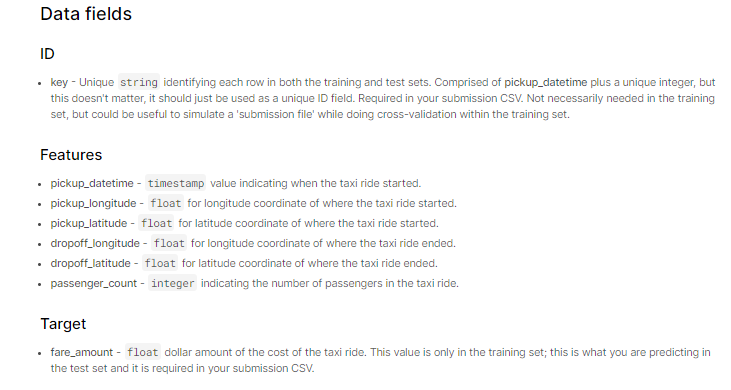

In [52]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [53]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [54]:
sample_submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [55]:
print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (1000000, 8)
Testing Features shape:  (9914, 7)


# Check missing value

In [56]:
#train
total = train.isnull().sum().sort_values(ascending=False)
percent = ((train.isnull().sum()/train.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(434)

,Total,Percent
dropoff_latitude,10,0.001
dropoff_longitude,10,0.001
passenger_count,0,0.000
pickup_latitude,0,0.000
pickup_longitude,0,0.000
pickup_datetime,0,0.000
fare_amount,0,0.000
key,0,0.000


There are 10 missing values, need to remove these rows later.

In [57]:
train = train.dropna(how='any')

In [58]:
train.shape

(999990, 8)

In [59]:
#Test
total = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(100)

,Total,Percent
passenger_count,0,0.0
dropoff_latitude,0,0.0
dropoff_longitude,0,0.0
pickup_latitude,0,0.0
pickup_longitude,0,0.0
pickup_datetime,0,0.0
key,0,0.0


There are no missing value in both of train and test data.

# Check data summary

In [60]:
from scipy import stats
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

resumetable(train)[:25]

Dataset Shape: (999990, 8)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,key,object,0,999990,2009-06-15 17:26:21.0000001,2010-01-05 16:52:16.0000002,2011-08-18 00:35:00.00000049,19.93
1,fare_amount,float64,0,2136,4.5,16.9,5.7,6.45
2,pickup_datetime,object,0,861747,2009-06-15 17:26:21 UTC,2010-01-05 16:52:16 UTC,2011-08-18 00:35:00 UTC,19.63
3,pickup_longitude,float64,0,113607,-73.8443,-74.016,-73.9827,15.91
4,pickup_latitude,float64,0,144938,40.7213,40.7113,40.7613,16.28
5,dropoff_longitude,float64,0,134494,-73.8416,-73.9793,-73.9912,16.08
6,dropoff_latitude,float64,0,171395,40.7123,40.782,40.7506,16.46
7,passenger_count,int64,0,8,1,1,2,1.51


In [61]:
resumetable(test)[:25]

Dataset Shape: (9914, 7)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,key,object,0,9914,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24.0000003,2011-10-08 11:53:44.0000002,13.28
1,pickup_datetime,object,0,1753,2015-01-27 13:08:24 UTC,2015-01-27 13:08:24 UTC,2011-10-08 11:53:44 UTC,8.87
2,pickup_longitude,float64,0,9125,-73.9733,-73.9869,-73.9825,13.11
3,pickup_latitude,float64,0,9247,40.7638,40.7194,40.7513,13.14
4,dropoff_longitude,float64,0,9142,-73.9814,-73.9989,-73.9797,13.11
5,dropoff_latitude,float64,0,9360,40.7438,40.7392,40.7461,13.16
6,passenger_count,int64,0,6,1,1,1,1.46


# EDA

Let's see the fare distribution.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


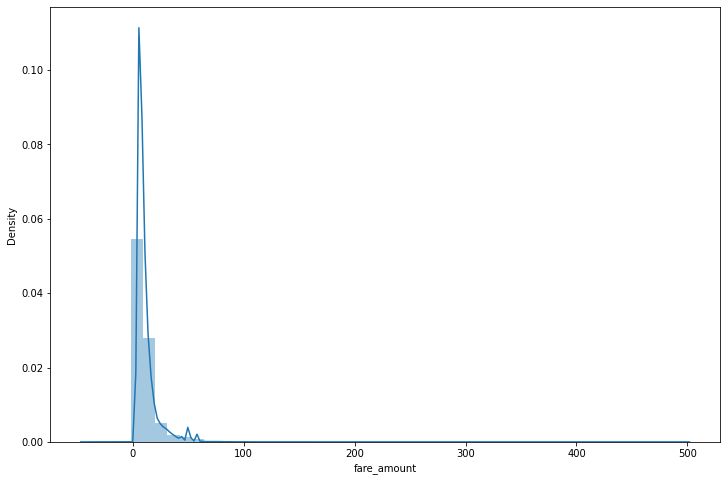

<Figure size 432x288 with 0 Axes>

In [62]:
plt.figure(figsize=(12,8))
sns.distplot( train['fare_amount'],  bins=50, kde=True);
fig = plt.figure()

Therea re some outlier, so need to remove these value.

In [63]:
###上位〇〇%, 下位△△%をulimit/llimitの値に置き換える(外れ値の除去)####################################
for col in ["fare_amount"]:
    ulimit = np.percentile(train[col].values, 99.5)
    llimit = np.percentile(train[col].values, 0.5)
    train[col].iloc[train[col]>ulimit] = ulimit
    train[col].iloc[train[col]<llimit] = llimit

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [64]:
train.shape

(999990, 8)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


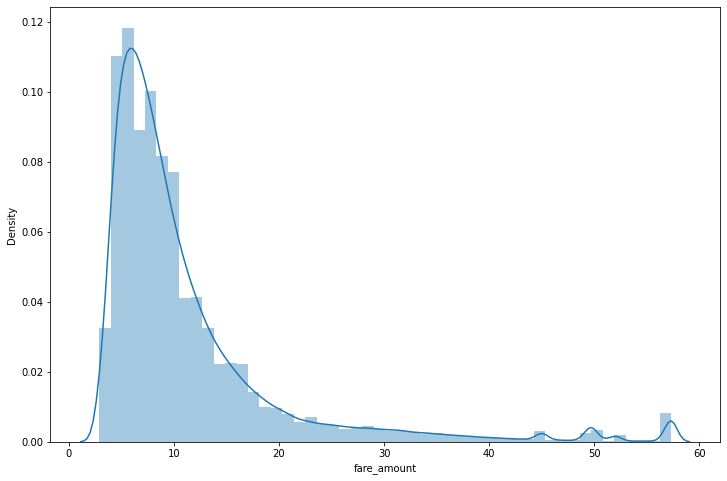

<Figure size 432x288 with 0 Axes>

In [65]:
plt.figure(figsize=(12,8))
sns.distplot( train['fare_amount'],  bins=50, kde=True);
fig = plt.figure()

# Preprocessing

Firstly, it seems key value fields are not needed, bacause these value is just ID and timestamp that is included in other variables.

In [10]:
train = train.drop(['key'], axis = 1)
test = test.drop(['key'], axis = 1)